# ADS Project 3 Group 4

## Libraries and Settings

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from scipy.io import loadmat
from sklearn.model_selection import StratifiedKFold


from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
"""
Path
"""
DATA_PATH = "../data/train_set"
IMAGE_FOLDER = os.path.join(DATA_PATH, "images")
POINTS_FOLDER = os.path.join(DATA_PATH, "points")
LABELS_FOLDER = DATA_PATH

## Read Training Data

In [3]:
def read_all_images(height = 750, width = 1000):
    """
    Read 2500 training images from the IMAGE_FOLDER
    :param height: resized height of images
    :param width: resized width of images
    :return: a 4d numpy array in form of (index, height, width, channels), channels is RGB 
    """
    files = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
    files.sort()
    
    face_images_arr = np.zeros((len(files), height, width, 3))
    
    for index, filename in enumerate(files):
        face_img = Image.open(os.path.join(IMAGE_FOLDER, filename))
        face_img = face_img.resize((width, height))
        face_images_arr[index] = np.array(face_img)
    return face_images_arr

def read_labels():
    """
    Read the image labels from the label.csv file
    :return: a pandas.DataFrame with 3 columns: 'emotion_idx','emotion_cat','type'
    """
    labels_df = pd.read_csv(os.path.join(LABELS_FOLDER, 'label.csv'))
    labels_df = labels_df.loc[:,['emotion_idx','emotion_cat','type']]
    return labels_df
    

def read_all_points():
    """
    Read all face coordinates points
    :return: a tuple of shape (2500, 78, 2). Because for each of 2500 images there are 78 points associated with it
    """
    files = [file for file in os.listdir(POINTS_FOLDER) if file.endswith('.mat')]
    files.sort()
    
    face_points = np.zeros((len(files), 78, 2))
    for index, filename in enumerate(files):
        face_points_dict = loadmat(os.path.join(POINTS_FOLDER, filename))
    
        face_points[index] = face_points_dict.get('faceCoordinatesUnwarped',  face_points_dict.get('faceCoordinates2'))
    return face_points

def load_data(loadImage = False, loadPoints = True, imageHeight = 750, imageWidth = 1000):
    """
    Load training data from local files
    
    :param loadImage: if it's False, this function will not load original images
    :return: a tuple (images, points, labels)
        if loadImage is False, the 'images' will None. Otherwise its a numpy array with shape (2500,750,1000,3)
        points is a numpy array with shape (2500, 78, 2)
        labels is a pandas.DataFrame
    """
    face_images_narr =  read_all_images(height=imageHeight, width=imageWidth) if loadImage else None
    face_images_points = read_all_points() if loadPoints else None
    labels = read_labels()
    return face_images_narr, face_images_points, labels



def show_image(index, all_images = None):
    """
    Display the (index)th image.
    all_images is passed, the this image numpy array can be easily retrieved from it. 
    Otherwise the original images needs to be read from disk
    
    :param index: the index to specify which image to disply
    :param all_images: the return value of 'read_all_images' function
    """
    if all_images is not None and index < len(all_images):
        face_img_arr = all_images[index].astype('uint8')
        
    else:
        face_img_arr = plt.imread(os.path.join(IMAGE_FOLDER, f"{index:04}.jpg"))
    plt.imshow(face_img_arr)
    plt.show()
    return 



In [4]:
# pass True if you want to read original images, it might take some time to do it
images, points, labels = load_data(loadImage=True, loadPoints=False, imageHeight = 300, imageWidth=400)

In [5]:
if images is not None:
    print("shape of image",images.shape)
    print(f"memory of image ndarray is {sys.getsizeof(images)/1024/1024/1024:.2f} GB")
if points is not None:
    print("shape of points",points.shape)

shape of image (2500, 300, 400, 3)
memory of image ndarray is 6.71 GB


## Proprocessing and Cross Validation Function

In [ ]:
"""
Preprocess the training data
change the type of images numpy array to save memory
"""

images = images.astype('float32')/255
# let the labels start from 0
y = labels['emotion_idx'].values - 1
print(images[0])

## Feedforward Neural Network

In [8]:
"""
Create nn model
"""
def create_ff_model(height = 300, width = 400, dim = 3, outputs = 22):
    """
    Create a feedforward model
    """
    ff_model = models.Sequential()
    ff_model.add(layers.Flatten(input_shape = (height, width, dim) ))
    ff_model.add(layers.Dense(32, activation='relu'))
    ff_model.add(layers.Dense(32, activation='relu'))
    ff_model.add(layers.Dense(outputs, activation='softmax'))

    ff_model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics = ['acc'])
    
    return ff_model

In [9]:
model = create_ff_model()
# model.summary()

images = 
categorical_y = to_categorical(y)
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(images, categorical_y, batch_size = 20, shuffle = True, seed = 13)
model.fit_generator(train_generator, epochs = 3, steps_per_epoch = 100)


Epoch 1/3
100/100 [==============================] - 15s 154ms/step - loss: 27.1501 - acc: 0.0390
Epoch 2/3
100/100 [==============================] - 15s 149ms/step - loss: 3.0909 - acc: 0.0480
Epoch 3/3
100/100 [==============================] - 15s 146ms/step - loss: 3.0906 - acc: 0.0445


In [ ]:
"""
K-fold validation
"""
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
height = 300
width = height * 4 / 3

for train_index, val_index in kfold.split(images, y):
    # split traning set and validation set
    X_train = images[train_index]
    y_train = y[train_index]
    X_validation = images[val_index]
    y_validation = y[val_index]
    
    # create data generator
    train_generator = train_datagen.flow(X_train, y_train, batch_size = 20, shuffle = True, seed = 13)
    y_train = to_categorical(y_train)
    
    ff_model = create_ff_model(height = height, width = width)
    ff_model.fit_generator(train_generator, epochs = 3, steps_per_epoch = 100)
    break
    
#     validation_generator = validation_datagen.flow(X_validation, y_validation, 
#                                                    batch_size = 20, shuffle = True, seed = 13)
    
    # convert to categorical labels
    
    y_validation = to_categorical(y_validation)
    
    
    acc = ff_model.evaluate(X_validation, y_validation)
    print(acc)
    # fit model
#     history = ff_model.fit_generator(train_generator, steps_per_epoch= 100,epochs=5,
#                             validation_data=validation_generator, validation_steps=25)
    

In [26]:
layers.Flatten?

In [25]:
model = create_ff_model()
model.fit(images, y, epochs = 10, batch_size = 20)

ValueError: Error when checking target: expected dense_27 to have shape (10,) but got array with shape (1,)

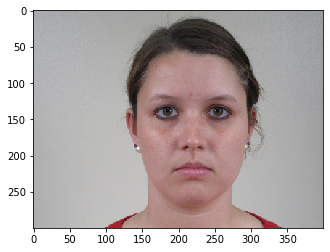

In [7]:
show_image(1, images)

## Convolutional Neural Network

In [22]:
def create_CNN_model(height = 300, width = 400, dim = 3, outputs = 22):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (height, width, dim)))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(outputs, activation = 'softmax'))
    
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
categorical_y = to_categorical(y)
model = create_CNN_model()
model.summary()
history = model.fit(images, categorical_y, epochs = 5, batch_size = 100)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 298, 398, 32)      896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 149, 199, 32)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 147, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 73, 98, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 71, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 35, 48, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 33, 46, 128)     